<u>接第二次作业鸢尾花数据集处理方法</u>

In [38]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn import datasets
from sklearn.model_selection import train_test_split
#from mlxtend.plotting import plot_decision_regions

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 替换sans-serif字体,用来正常显示中文标签,可选['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号, 注意['SimHei']对应这句不行.
#import seaborn as sns
import numpy as np
import pandas as pd

In [39]:
# 代码同第二次作业，除了没有std处理以及 X_combined, y_combined 的值有变化。
iris = datasets.load_iris() 
y = iris.target
X = pd.DataFrame(data=iris.data[:, [2, 3]], columns=np.array(iris.feature_names)[[2,3]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    #画决策边界,AX是特征，y是标签，classifier是分类器，test_idx是测试集序号
    #设置标记生成器和彩色地图
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
 
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1   #第一个特征取值范围作为横轴
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1   #第二个特征取值范围作为纵轴
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))  #reolution是网格剖分粒度，xx1和xx2数组维度一样
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)   
    #classifier指定分类器，ravel是数组展平；Z的作用是对组合的二种特征进行预测
    Z = Z.reshape(xx1.shape)   #Z是列向量
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)  
    #contourf(x,y,z)其中x和y为两个等长一维数组，z为二维数组，指定每一对xy所对应的z值。
    #对等高线间的区域进行填充（使用不同的颜色）
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
 
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=[cmap(idx)],
                    marker=markers[idx], label=cl)   #全数据集，不同类别样本点的特征作为坐标(x,y)，用不同颜色画散点图
 
    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]   #X_test取测试集样本两列特征，y_test取测试集标签
 
        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    edgecolors='black',
                    s=55, label='test set')   #c设置颜色，测试集不同类别的实例点画图不区别颜色

# 1. Decision Trees(DTs)

**优点**：
<br>1.易于理解和解释。树可以被可视化。
<br>2.几乎不需要整理数据，如正则化、创建虚拟变量、删除空白值。但是DTs不支持缺失值。
<br>3.时间复杂度较小，是用于训练决策树的数据点的对数。
<br>4.相比于其他算法只能分析一种类型变量，决策树可处理数字和数据的类别。
<br>5.能够处理多输出的问题。

[关于决策树的优缺点(直译自API)](https://blog.csdn.net/weixin_41540084/article/details/99325672?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522165303177116780357249393%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=165303177116780357249393&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-2-99325672-null-null.142^v10^pc_search_result_control_group,157^v4^control&utm_term=%E5%86%B3%E7%AD%96%E6%A0%91%E4%BC%98%E7%BC%BA%E7%82%B9&spm=1018.2226.3001.4187)

[决策树参数详解](https://blog.csdn.net/ywj_1991/article/details/122962524?spm=1001.2101.3001.6650.1&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1-122962524-blog-99227299.pc_relevant_default&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1-122962524-blog-99227299.pc_relevant_default&utm_relevant_index=2)

**参数**：

    clf = tree.DecisionTreeClassifier(
         常用参数
        class_weight=None # 设置各类别样本的权重，默认各个样本权重一样，都为1。
        ccp_alpha=0.0 # 需要剪枝时设置该alpha参数，默认不会剪枝。
        random_state # 需要每次训练都一样时，就需要设置该参数。
        criterion="gini" # 节点质量评估函数（gini,entropy)
        基尼指数：从数据集中随机抽取的两个样本，其类别标记不一致的概率。基尼指数越小，数据集的纯度越高。一般而言，数据维度较高，噪音较多选择基尼指数；而当决策树的拟合程度不够时，使用信息熵（信息熵对不纯度更加敏感）。

        预防过拟合参数
        min_samples_leaf=1 # 叶子节点（不可划分）最少的样本数，可以是整数，也可以是浮点数——百分比样本数。
        min_samples_split=2 # 节点分枝最小样本个数。某个分裂节点的样本数目非常少，不适合继续分裂。
        max_depth=None # 树分枝的最大深度。
        min_weight_fraction_leaf=0 # 叶子节点最小权重和。
        min_impurity_decrease=0 # 节点分枝最小纯度增长量。每一个决策的特征对决策结果的提升必须大于指定阈值。
        max_leaf_nodes=None # 最大叶子节点数。

        树的多样性参数（训练弱树常用以下参数）：
        max_features=None # 寻找最优划分的最大特征数。
        splitter="best" # 分枝时变量选择方式（“best”和“random”）。
            )         
**方法与属性**：

    预测与评估
    clf.predict(X) # 预测X的类别
    clf.predict_proba(X) # 预测X属于各类的概率
    clf.predict_log_proba(X) # 相当于 np.log(clf.predict_proba())
    clf.apply(X) # 返回样本预测节点的索引
    clf.score(X,y) # 返回准确率，即模型预测值与y不同的个数占比(支持样本权重：clf.score(X,y,sample_weight=sample_weight))
    clf.decision_path(np.array([0 ,1 ,2 ,1 ]).reshape(1, -1)).todense() # 返回决策路径：格式[ 1 1 0 0 0] ，它代表通过了第0，第1个节点。

    剪枝
    clf.cost_complexity_pruning_path(X, y) # 返回 CCP(Cost Complexity Pruning代价复杂度剪枝)法的剪枝路径。
    
    树信息
    clf.get_depth()           ：返回树的深度
    clf.get_n_leaves()      ：叶子节点个数
    clf.tree_.node_count  ：总节点个数

    树明细数据
    左节点编号  :  clf.tree_.children_left  
    右节点编号  :  clf.tree_.children_right  
    分割的变量  :  clf.tree_.feature   
    分割的阈值  :  clf.tree_.threshold
    不纯度(gini) :  clf.tree_.impurity
    样本个数     :  clf.tree_.n_node_samples  
    样本分布     :  clf.tree_.value  

    其它
    clf.feature_importances_  ：各个特征的权重。
    clf.get_params()                ：查看模型的入参设置
    如果想获取节点上样本的数据，sklearn不直接提供，但可以借用 clf.apply(X) ，把原数据作为输入，间接获得。

<ipython-input-39-ee4b40bdf151>:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


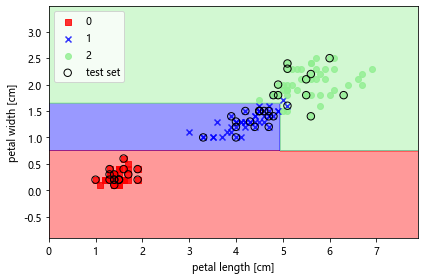

测试集准确度：97.78%
其他指标：
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



In [56]:
dtclf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
# criterion特征选择的度量，entropy是信息增益；max_depth是数的最大深度
dtclf.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, classifier=dtclf, test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

y_pred = dtclf.predict(X_test)
print('测试集准确度：%.2f%%' % (100 * accuracy_score(y_test, y_pred)))
print("其他指标：\n", classification_report(y_test, y_pred, target_names=['0', '1', '2']))

[Text(125.55000000000001, 190.26, 'petal width (cm) <= 0.75\nentropy = 1.58\nsamples = 105\nvalue = [34, 32, 39]'),
 Text(83.7, 135.9, 'entropy = 0.0\nsamples = 34\nvalue = [34, 0, 0]'),
 Text(167.4, 135.9, 'petal length (cm) <= 4.95\nentropy = 0.993\nsamples = 71\nvalue = [0, 32, 39]'),
 Text(83.7, 81.53999999999999, 'petal width (cm) <= 1.65\nentropy = 0.431\nsamples = 34\nvalue = [0, 31, 3]'),
 Text(41.85, 27.180000000000007, 'entropy = 0.0\nsamples = 30\nvalue = [0, 30, 0]'),
 Text(125.55000000000001, 27.180000000000007, 'entropy = 0.811\nsamples = 4\nvalue = [0, 1, 3]'),
 Text(251.10000000000002, 81.53999999999999, 'petal length (cm) <= 5.05\nentropy = 0.179\nsamples = 37\nvalue = [0, 1, 36]'),
 Text(209.25, 27.180000000000007, 'entropy = 0.811\nsamples = 4\nvalue = [0, 1, 3]'),
 Text(292.95, 27.180000000000007, 'entropy = 0.0\nsamples = 33\nvalue = [0, 0, 33]')]

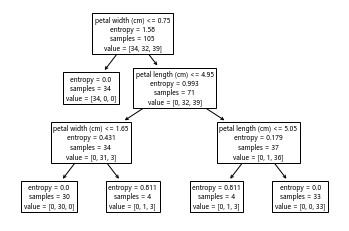

In [41]:
tree.plot_tree(dtclf,feature_names=X.columns)

In [42]:
text=tree.export_text(dtclf,feature_names=X.columns.to_list())
print(text)

|--- petal width (cm) <= 0.75
|   |--- class: 0
|--- petal width (cm) >  0.75
|   |--- petal length (cm) <= 4.95
|   |   |--- petal width (cm) <= 1.65
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  1.65
|   |   |   |--- class: 2
|   |--- petal length (cm) >  4.95
|   |   |--- petal length (cm) <= 5.05
|   |   |   |--- class: 2
|   |   |--- petal length (cm) >  5.05
|   |   |   |--- class: 2



# 2. Random Forests
 
包括 RandomForestClassifier 和 RandomForestRegressor
<br>[随机森林详解](https://blog.csdn.net/oax_knud/article/details/118880442?ops_request_misc=&request_id=&biz_id=102&utm_term=%E9%9A%8F%E6%9C%BA%E6%A3%AE%E6%9E%97%E5%8F%82%E6%95%B0%E8%AF%A6%E8%A7%A3%EF%BC%88python%E4%BB%A3%E7%A0%81%EF%BC%89&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-0-118880442.142^v10^pc_search_result_control_group,157^v4^control&spm=1018.2226.3001.4187)

**参数**：

    (和决策树相同的参数)
    criterion	
    random_state
    max_depth	
    min_samples_leaf	
    min_samples_split	
    max_features	
    min_impurity_decrease
    
    
    (和决策树不同的参数)
    n_estimators 
    # 森林中树木的数量，即基评估器的数量。越大，模型的效果往往越好但需要的计算量和内存也越大，训练的时间也会越来越长。达到一定的程度之后，随机森林的精确性往往不再上升或开始波动。对于这个参数，我们应该在训练难度和模型效果之间取得平衡。
    
    bootstrap 
    # 用来控制抽样技术的参数。默认True，代表采用有放回的随机抽样技术（有放回抽样也会有自己的问题。由于是有放回，一些样本可能在同一个自助集中出现多次，而其他一些却可能被忽略，自助集大约平均会包含63%的原始数据。），通常，这个参数不会被我们设置为False。
    
    oob_score 
    # 会有约37%的训练数据被浪费掉，没有参与建模，这些数据被称为袋外数据(out of bag data，简写为oob)。除了我们最开始就划分好的测试集之外，这些数据也可以被用来作为集成算法的测试集。也就是说，在使用随机森林时，我们可以不划分测试集和训练集，只需要用袋外数据来测试我们的模型即可。如果希望用袋外数据来测试，需要在实例化时就将oob_score这个参数调整为True。

    

<ipython-input-39-ee4b40bdf151>:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


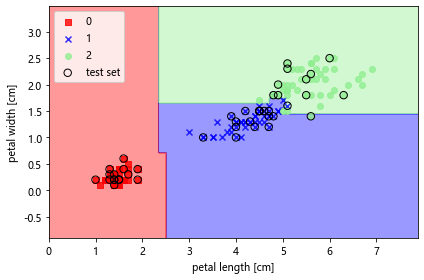

测试集准确度：95.56%
其他指标：
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.94      0.94      0.94        18
           2       0.91      0.91      0.91        11

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



In [43]:
forest = RandomForestClassifier(criterion='entropy', n_estimators=10, n_jobs=2, random_state=1)
# n_estimators随机森林中多少棵树，n_jobs设置并行生成树模型的数目
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, classifier=forest, test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

y_pred = forest.predict(X_test)
print('测试集准确度：%.2f%%' % (100 * accuracy_score(y_test, y_pred)))
print("其他指标：\n", classification_report(y_test, y_pred, target_names=['0', '1', '2']))

<ipython-input-39-ee4b40bdf151>:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


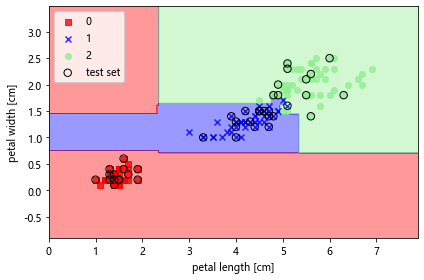

测试集准确度：97.78%
其他指标：
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



In [63]:
forest = RandomForestClassifier(criterion='entropy', n_estimators=45, n_jobs=4, random_state=1)
# n_estimators随机森林中多少棵树，n_jobs设置并行生成树模型的数目
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, classifier=forest, test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

y_pred = forest.predict(X_test)
print('测试集准确度：%.2f%%' % (100 * accuracy_score(y_test, y_pred)))
print("其他指标：\n", classification_report(y_test, y_pred, target_names=['0', '1', '2']))

**决策树设置 max_depth 的值为3或4时，准确度最高，为97.78%，5以后反而降低。随机森林设置 n_estimators 的值大于等于45后，测试集准确度保持在97.78%不再增加。不知这是巧合还是划分的数据集有局限性还是其中确有规律。通过更多实验相信能得出更多信息。**